In [105]:
using DelimitedFiles, Distributions, Plots

In [106]:
function moments(::Type{Gamma}, mean::Real, var::Real)
    shape = mean^2 / var
    scale = var / mean
    return Gamma(shape, scale)
end

moments (generic function with 1 method)

In [107]:
function quantile_ribbon(dist)
    quantiles = quantile.(dist, [0.025, 0.975])
    return quantiles[1], quantiles[2]
end

quantile_ribbon (generic function with 1 method)

In [108]:
sunspot = readdlm("../data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020);

# to check that matched with Semih
cvi = readdlm("../estimations/cvi_sunspot_results.csv")
cvmp = readdlm("../estimations/cvmp_sunspot_results.csv")
aismp = readdlm("../estimations/ais_mp_sunspot_results.csv")
nuts = readdlm("../estimations/nuts_sunspot_results.csv");

inference_results = [
    aismp,    
    cvmp,
    cvi,
    nuts
];

gammas = map(
    (result) -> moments.(Gamma, result[:, 1], result[:, 2]), 
    inference_results
);

custom_colors = [:red, :blue, :green, :orange];
algorithms = ["AISMP", "CVMP", "SVMP", "NUTS"];
linestyles = [:dash, :solid, :dot, :dashdot];
selected = 1:3

1:3

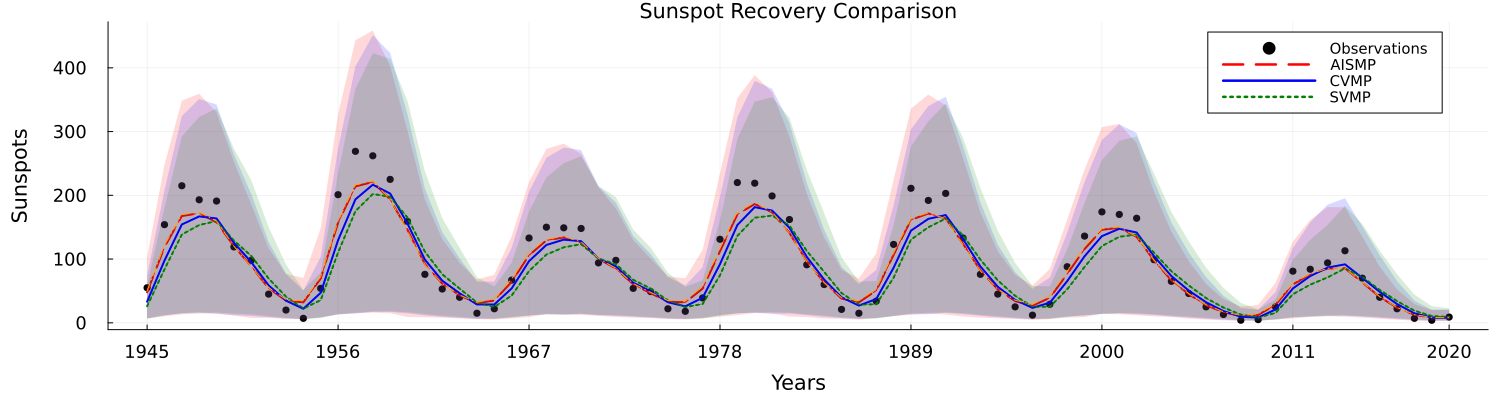

In [109]:
gamma_based_estimation_plot = plot(title="Sunspot Recovery Comparison",
                       guidefontsize=14,
                       tickfontsize=12,
                       legendfontsize=10,
                       legend=:topright,
                       size=(1500, 400)
)

scatter!(gamma_based_estimation_plot, observations, color=:black,
         xtick=([1, 12, 23, 34, 45, 56, 67, 76], [1945, 1956, 1967, 1978, 1989, 2000, 2011, 2020]),
         xlabel="Years", ylabel="Sunspots", label="Observations", left_margin=10Plots.mm, bottom_margin=10Plots.mm)

for (i, (algorithm, gamma, color, linestyle)) in enumerate(zip(algorithms, gammas, custom_colors, linestyles, selected))
    lower, upper = zip(quantile_ribbon.(gammas[i])...) |> collect;
    lower, upper = [lower...], [upper...]
    plot!(gamma_based_estimation_plot, mean.(gammas[i]), ribbon=(lower, upper), label=algorithm, lw=2, color=color, linestyle = linestyle, fillalpha=0.15)
end

for (i, (algorithm, gamma, color, linestyle)) in enumerate(zip(algorithms, gammas, custom_colors, linestyles))
    plot!(gamma_based_estimation_plot, mean.(gamma), label=false, color=color, linestyle = linestyle)
end

gamma_based_estimation_plot

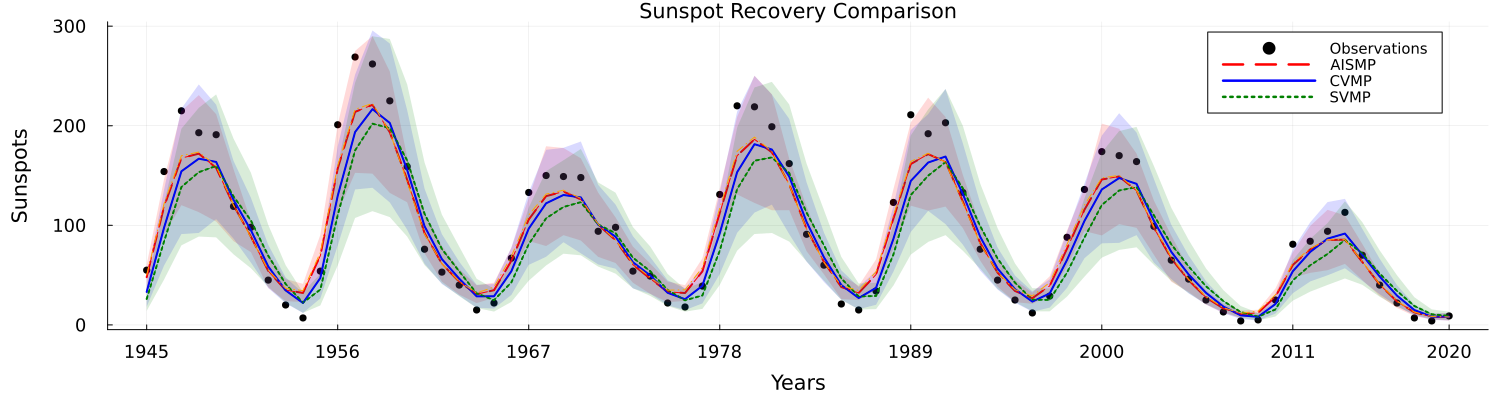

In [110]:
estimation_plot = plot(title="Sunspot Recovery Comparison",
                       guidefontsize=14,
                       tickfontsize=12,
                       legendfontsize=10,
                       legend=:topright,
                       size=(1500, 400)
)

scatter!(estimation_plot, observations, color=:black,
         xtick=([1, 12, 23, 34, 45, 56, 67, 76], [1945, 1956, 1967, 1978, 1989, 2000, 2011, 2020]),
         xlabel="Years", ylabel="Sunspots", label="Observations", left_margin=10Plots.mm, bottom_margin=10Plots.mm)

for (i, (algorithm, gamma, color, linestyle)) in enumerate(zip(algorithms, gammas, custom_colors, linestyles, selected))
    plot!(estimation_plot, mean.(gamma), ribbon=var.(gamma), label=algorithm, lw=2, color=color, linestyle = linestyle, fillalpha=0.15)
end

for (i, (algorithm, gamma, color, linestyle)) in enumerate(zip(algorithms, gammas, custom_colors, linestyles))
    plot!(mean.(gamma), label=false, color=color, linestyle = linestyle)
end

estimation_plot

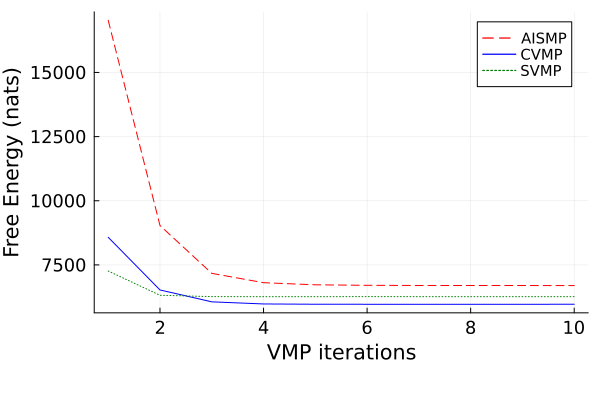

In [111]:
# to check that matched with Semih
cvi_fe = readdlm("../estimations/cvi_fe_sunspot_results.csv")
cvmp_fe = readdlm("../estimations/cvmp_fe_sunspot_results.csv")
aismp_fe = readdlm("../estimations/ais_mp_fe_results.csv")
fe_list = [aismp_fe, cvmp_fe, cvi_fe]


fe_plot = plot(
    xlabel="VMP iterations",
    ylabel="Free Energy (nats)",
    guidefontsize=14,
    tickfontsize=12,
    legendfontsize=10,
    legend=:topright,
    bottom_margin=10Plots.mm
)

for (i, (algorithm, data, color, linestyle)) in enumerate(zip(algorithms, fe_list, custom_colors, linestyles))
    plot!(data[1, :], label=algorithm, color=color, linestyle = linestyle)
end

fe_plot

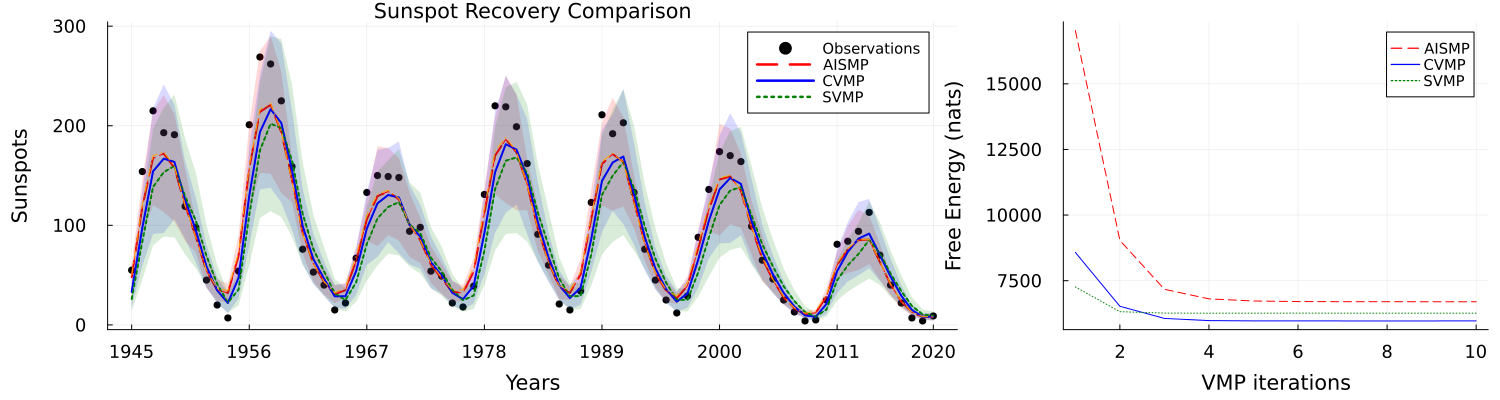

In [112]:
plot(estimation_plot, fe_plot, layout=grid(1, 2, widths=(2/3,1/3)))

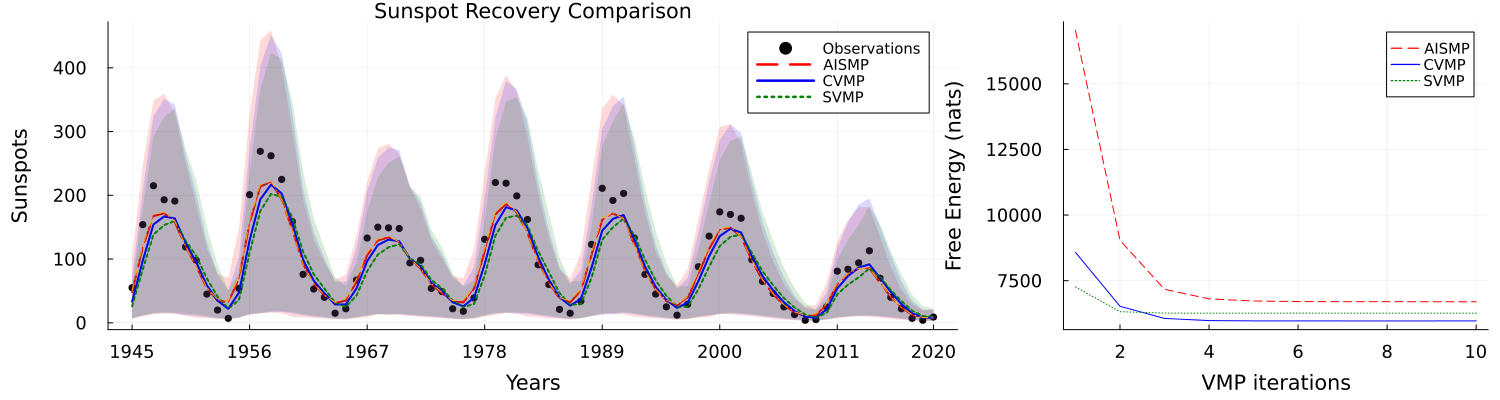

In [113]:
plot(gamma_based_estimation_plot, fe_plot, layout=grid(1, 2, widths=(2/3,1/3)))